In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import homogeneity_completeness_v_measure
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import cv2
import glob
from PIL import Image
import regex

In [2]:
def read_images():
    image_samples=[]
    boundries=[]
    segmentation_Gt=[]
    images_list=[]
    path= 'BSR/BSDS500/data/images/train/'
    path_mat= 'BSR/BSDS500/data/groundTruth/train/'
    for filename in glob.glob(path+"*.jpg"): 
        im=Image.open(filename) #read file name 
        img = np.array(im) # convert pil to numpy array
        images_list.append(img) 
        image_samples.append(img.reshape(img.shape[0]*img.shape[1], 3)) # reshape to samples 
        image_number=regex.split(r'.jpg',regex.split(r'/', filename)[5])[0] # get the number of the image
        temp= sio.loadmat(path_mat+image_number) # read boundries, groundtruth
        boundries.append(temp['groundTruth'][0][0]['Boundaries'][0][0]) #extract boundries 
        segmentation_Gt.append(temp['groundTruth'][0][0]['Segmentation'][0][0]) #extract ground truth
    return images_list, image_samples, boundries, segmentation_Gt

In [3]:
def visualize(img,segmentation_Gt,boundries ):
    m=plt.figure(1)
    plt.imshow(img)
    m.show()
    
    s=plt.figure(2)
    plt.imshow(segmentation_Gt)
    s.show()
    
    b=plt.figure(3)
    plt.imshow(boundries)
    b.show()

In [4]:
def evaluate(y_pred, y_true):
    #if (meaure=="F_measure"):
    F_measure_score= f1_score(y_true, y_pred, average=None)
    #else if(measure== "conditional_entropy"):
    conditional_entropy_score= homogeneity_completeness_v_measure(y_true, y_pred)
    print("F-measure=", F_measure_score, "\n conditional entropy score=",conditional_entropy_score )
    return F_measure_score, conditional_entropy_score

In [5]:
def NN_cut():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-5-448825d23ca0>, line 2)

/home/alaasameh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


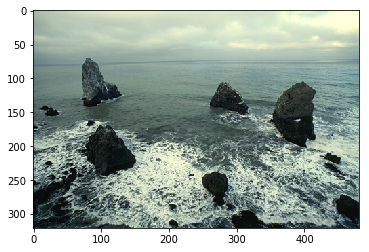

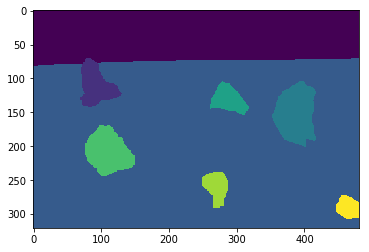

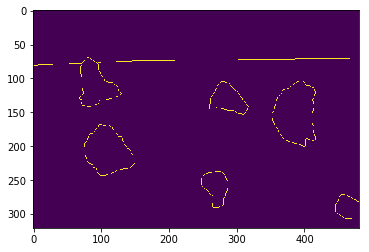

In [6]:
#loop through images and visualize, cluster with kmeans and normalizd_cut 
#and evaluate using F_measure and condtional entropy

images_list,image_samples, boundries, segmentation_Gt= read_images() #read images
visualize(images_list[0],segmentation_Gt[0],boundries[0] ) # visualization

# kmeans 
# normalized_cut
#F_measure_score, conditional_entropy_score= evaluate(y_pred, y_true) #evaluation 
